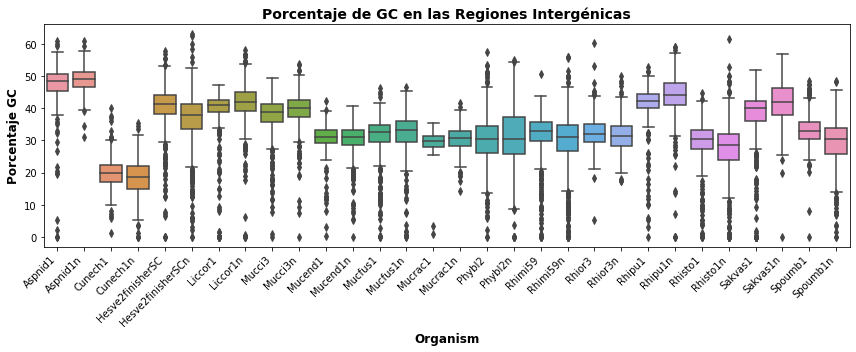

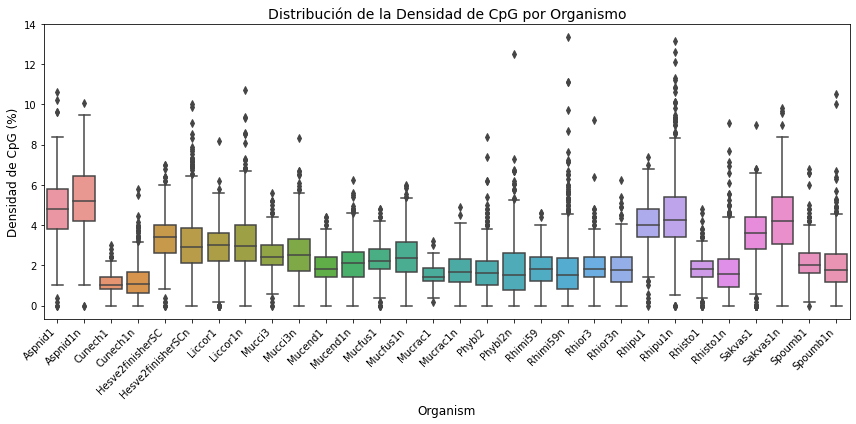

In [11]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO

def calcular_porcentaje_gc(secuencia):
    """Calcula el porcentaje de GC en una secuencia dada."""
    gc_conteo = secuencia.count('G') + secuencia.count('C')
    longitud = len(secuencia)
    return (gc_conteo / longitud) * 100 if longitud > 0 else 0

def calcular_densidad_cpg(secuencia):
    """Calcula la densidad de dinucleótidos CpG en la secuencia."""
    return secuencia.count("CG") / len(secuencia) * 100 if len(secuencia) > 0 else 0

# Obtener la lista de archivos que terminan en _promoters_seq.txt
archivos_promotores = glob.glob("*_promoters_seq.txt")

# Crear listas para almacenar los DataFrames de GC y CpG por organismo
datos_gc = []
datos_cpg = []

for archivo in archivos_promotores:
    # Extraer el primer campo del nombre del archivo para el nombre del organismo
    nombre_organismo = os.path.basename(archivo).split('_')[0]
    
    # Leer las secuencias del archivo
    for record in SeqIO.parse(archivo, "fasta"):
        secuencia = str(record.seq)
        
        # Calcular porcentaje de GC y densidad de CpG
        gc_content = calcular_porcentaje_gc(secuencia)
        cpg_density = calcular_densidad_cpg(secuencia)
        
        # Agregar los datos a las listas
        datos_gc.append({'Organismo': nombre_organismo, 'GC_Content': gc_content})
        datos_cpg.append({'Organismo': nombre_organismo, 'CpG_Density': cpg_density})

# Convertir las listas en DataFrames
df_gc_total = pd.DataFrame(datos_gc)
df_cpg_total = pd.DataFrame(datos_cpg)

# Ordenar los DataFrames por el nombre del organismo
df_gc_total = df_gc_total.sort_values(by='Organismo')
df_cpg_total = df_cpg_total.sort_values(by='Organismo')

# Crear el boxplot para porcentaje de GC
plt.figure(figsize=(12, 5))
sns.boxplot(x='Organismo', y='GC_Content', data=df_gc_total)
plt.xlabel('Organism', fontsize=12,  fontweight='bold')
plt.ylabel('Porcentaje GC', fontsize=12,  fontweight='bold')
plt.title('Porcentaje de GC en las Regiones Intergénicas', fontsize=14,  fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Guardar el gráfico como archivo SVG
nombre_salida_gc = "distribucion_porcentaje_gc_por_organismo.svg"
plt.savefig(nombre_salida_gc, format='svg')

# Mostrar el gráfico
plt.show()

# Crear el boxplot para densidad de CpG
plt.figure(figsize=(12, 6))
sns.boxplot(x='Organismo', y='CpG_Density', data=df_cpg_total)
plt.xlabel('Organism', fontsize=12)
plt.ylabel('Densidad de CpG (%)', fontsize=12)
plt.title('Distribución de la Densidad de CpG por Organismo', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Guardar el gráfico como archivo SVG
nombre_salida_cpg = "distribucion_densidad_cpg_por_organismo.svg"
plt.savefig(nombre_salida_cpg, format='svg')

# Mostrar el gráfico
plt.show()


In [4]:
def contar_cajas_tata(secuencia):
    """Cuenta el número de cajas TATA en una secuencia."""
    return len(re.findall("TATA[AT]A", secuencia))


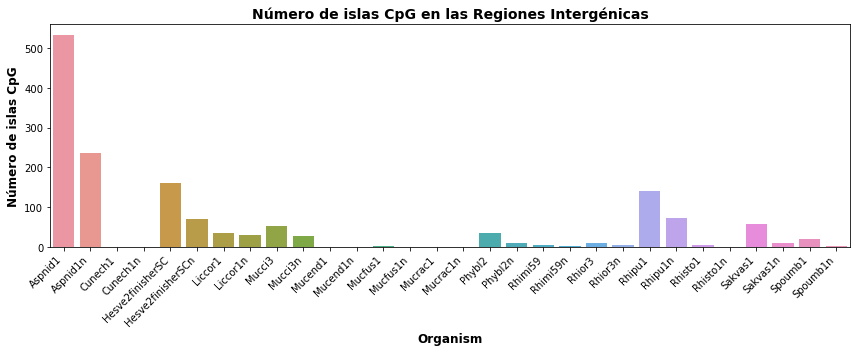

In [9]:
import glob
import os
import pandas as pd
import re
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt

def cpG_islands(sequence):
    """
    Finds CpG islands in a DNA sequence using the method of Gardiner-Garden and Frommer (1987).

    Args:
        sequence: A DNA sequence string.

    Returns:
        A list of tuples, where each tuple represents a non-overlapping CpG island and contains its start and end indices.
    """
    cpg_islands = []
    window_length = 200
    i = 0
    while i <= len(sequence) - window_length:
        window = sequence[i:i+window_length]
        c_count = window.count('C')
        g_count = window.count('G')
        cg_count = len(re.findall('CG', window))
        if c_count > 0 and g_count > 0:
            obs_exp = (cg_count * window_length) / (c_count * g_count)
        else:
            obs_exp = 0
        gc_content = (c_count + g_count) / window_length
        if obs_exp > 0.6 and gc_content > 0.5:
            # Check for overlap with existing islands
            overlapping = False
            for island in cpg_islands:
                if island[0] <= i <= island[1] or i <= island[0] <= i+window_length-1:
                    overlapping = True
                    break

            if not overlapping:
                cpg_islands.append((i, i+window_length-1))

            # Skip the window length to avoid double counting overlapping islands
            i += window_length
        else:
            i += 1

    return cpg_islands


# Obtener la lista de archivos que terminan en _promoters_seq.txt
archivos_promotores = glob.glob("*_promoters_seq.txt")

# Crear listas para almacenar los DataFrames de GC, CpG y TATA por organismo
datos_tata = []
datos_cpg = []

for archivo in archivos_promotores:
    # Extraer el primer campo del nombre del archivo para el nombre del organismo
    nombre_organismo = os.path.basename(archivo).split('_')[0]
    
    # Leer las secuencias del archivo
    for record in SeqIO.parse(archivo, "fasta"):
        secuencia = str(record.seq)
        
        # Calcular densidad de CpG y contar cajas TATA
        tata_count = contar_cajas_tata(secuencia)
        islas_cpg = cpG_islands(secuencia)
        
        # Agregar los datos a las listas
        datos_tata.append({'Organismo': nombre_organismo, 'TATA_Count': tata_count})
        
        if islas_cpg:
            cpg_count = len(islas_cpg)
        else:
            cpg_count = 0
            
        datos_cpg.append({'Organismo': nombre_organismo, 'CpG_Count': cpg_count})

# Convertir las listas a DataFrames de pandas
df_tata = pd.DataFrame(datos_tata)
df_cpg = pd.DataFrame(datos_cpg)
# Convertir la columna "CpG_Count" a tipo entero
df_cpg["CpG_Count"] = df_cpg["CpG_Count"].astype(int)

df_cpg.to_csv("islasCpG_allfungi.csv")

# Agrupar por organismo y sumar las islas CpG
df_cpg_sum = df_cpg.groupby('Organismo')['CpG_Count'].sum().reset_index()

# Mostrar algunos datos
#print(df_tata)
#print(df_cpg_sum)

# Visualización (opcional)
plt.figure(figsize=(12, 5))
sns.barplot(data=df_cpg_sum, x='Organismo', y='CpG_Count')
plt.title('Número de islas CpG en las Regiones Intergénicas', fontsize=14, fontweight='bold')
plt.xlabel('Organism', fontsize=12, fontweight='bold')
plt.ylabel('Número de islas CpG', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# Guardar el gráfico como archivo SVG
nombre_salida = "CpG_islands_promotores_por_organismo.svg"
plt.savefig(nombre_salida, format='svg')

plt.show()


